## sp_tutrial.py

In [1]:
"""
Spatial Pooler のいくつかの機能を示す簡単なチュートリアルです。

以下のプログラムは、いくつかの
空間プーラーの基本的なプロパティを説明します。本論文の図 5,7,9 を再現しています。
本論文から 5, 7, 9 を再現しています: http://arxiv.org/abs/1505.02142
Spatial Poolerの詳細については、BAMIをご覧ください。
http://numenta.com/biological-and-machine-intelligence/
または、NuPIC ドキュメントのクラスリファレンスを参照してください。
http://numenta.org/docs/nupic/classnupic_1_1research_1_1spatial__pooler_1_1_spatial_pooler.html
空間プーラーの目的は、疎な表現を作成することです。
にマッピングされます。
疎な表現が必要となります。したがって、空間プーラーは、ある程度の弾力性を示すべきです。
入力のノイズに対応しています。
"""

import numpy as np
import random
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt

from htm.bindings.sdr import SDR
from htm.algorithms import SpatialPooler as SP

%matplotlib inline

In [3]:
def percentOverlap(x1, x2):
  """
  SDR x1 と x2 の重複率を計算します。
  引数 x1 は SDR
  引数 x2 は SDR
  percentOverlap (float) 
  Returns percentOverlap (float)
  x1 と x2 の重なりの割合を返します。
  """
  minX1X2 = min(x1.getSum(), x2.getSum())
  percentOverlap = 0
  if minX1X2 > 0:
    percentOverlap = float( x1.getOverlap( x2 )) / minX1X2
  return percentOverlap


In [4]:
def corruptSDR(sdr, noiseLevel):
  """
  バイナリベクトルのビットの noiseLevel をパーセント反転させることで，バイナリベクトルを破損させます．

  @param vector (array) 破壊されるバイナリベクトル．
  @param noiseLevel （float） ベ ク タ ーに適用 し たい ノ イ ズの量
  """
  vector = sdr.flatten().dense
  for i in range(sdr.size):
    rnd = random.random()
    if rnd < noiseLevel:
      if vector[i] == 1:
        vector[i] = 0
      else:
        vector[i] = 1
  sdr.dense = vector

In [5]:
inputSDR  = SDR( dimensions = (1000,1) ).randomize( .50 )
outputSDR = SDR( dimensions = (2048,1) )

sp = SP(inputSDR.dimensions,
        outputSDR.dimensions,
        potentialRadius = int(0.5 * inputSDR.size),
        localAreaDensity = .02,
        globalInhibition = True,
        seed = 0,
        synPermActiveInc = 0.01,
        synPermInactiveDec = 0.008)


---------------------------------
図1はオーバーラップスコアのヒストグラムを示しています
空間プーラーのすべてのカラムから、および
を構築するために選択された列のオーバーラップスコアを表示します。
入力の疎な表現（緑色で表示）
SPは最大のオーバーラップスコアを持つ列の2%を選択する
このような疎な表現をするために
---------------------------------



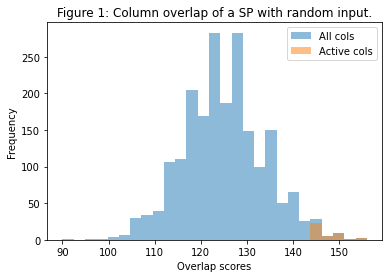

In [6]:
# パート1
# -------
# 列は，入力ベクトルのサブセットに接続されます（指定された
#ポテンシャル半径とポテンシャルPctの両方による) #. オーバーラップスコア
# となる入力への接続数です.
# ベクトルが提示されたときにアクティブになります。SPで学習が「オン」のとき。
# アクティブな接続は強化されていますが、 アクティブでない接続は
#(パラメータ synPermActiveInc と synPermInactiveDec に応じて) 
# 抑制された状態になります.
# SPが入力の疎な表現を作成するためには
# は、最もアクティブなカラムの中から小さなパーセンテージ(通常は2%)を選択します。
# つまり, 重複スコアが最も大きい列.
# この最初のパートでは, 重複スコアを示すヒストグラムを作成します.
#ランダムなバイナリで給餌した後の空間プーラー（SP）の ナンバー.
# input. 同様に, ヒストグラムはこれらの列のスコアを表示します.
# 入力の疎な表現を構築するために選択されます.

overlaps = sp.compute(inputSDR, False, outputSDR)
activeColsScores = []
for i in outputSDR.sparse:
  activeColsScores.append(overlaps[i])

print("")
print("---------------------------------")
print("図1はオーバーラップスコアのヒストグラムを示しています")
print("空間プーラーのすべてのカラムから、および")
print("を構築するために選択された列のオーバーラップスコアを表示します。")
print("入力の疎な表現（緑色で表示）")
print("SPは最大のオーバーラップスコアを持つ列の2%を選択する")
print("このような疎な表現をするために")
print("---------------------------------")
print("")

bins = np.linspace(min(overlaps), max(overlaps), 28)
plt.hist(overlaps, bins, alpha=0.5, label="All cols")
plt.hist(activeColsScores, bins, alpha=0.5, label="Active cols")
plt.legend(loc="upper right")
plt.xlabel("Overlap scores")
plt.ylabel("Frequency")
plt.title("Figure 1: Column overlap of a SP with random input.")
#plt.savefig("figure_1")
plt.show()


---------------------------------
図2は，2つの同一の2値ベクトル間の入力オーバラップを示しています
それらのうちの1つに適用されたノイズの関数
ノイズレベルが0の場合，ベクトルが変わらないことを意味します．
1はベクトルが元のベクトルの論理否定であることを意味します。
オーバーラップとノイズレベルの関係は実質的に線形である
そして単調に減少する
---------------------------------



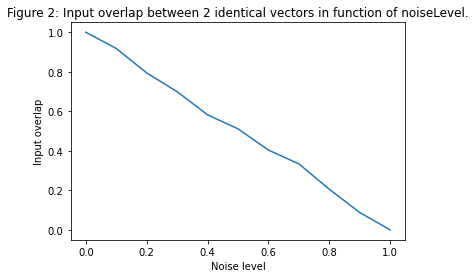

In [7]:
# パート2a.
# -------
# 2つの2値ベクトル間の重なりは, その点積として定義されます.
# この値を正規化するために, 最小限のアクティブな(どちらのベクトルでも) 
# 入力. これは, スパースベクトルを次のように考えています.
# reference. 2つの同一の2値ベクトルは1の入力オーバーラップを持つことになります。
# 2つの全く異なるベクトル(一方は他方の論理的なNOT)であるのに対し
# このセクションでは、入力されたオーバーラップがどのように
# 2つの2値ベクトルのうちの1つにノイズを加えると減少します.

inputX1 = SDR( inputSDR.size ).randomize( .50 )
inputX2 = SDR( inputSDR.size )
outputX1 = SDR( outputSDR.size )
outputX2 = SDR( outputSDR.size )

x = []
y = []
for noiseLevel in np.arange(0, 1.1, 0.1):
  inputX2.setSDR( inputX1 )
  corruptSDR(inputX2, noiseLevel)
  x.append(noiseLevel)
  y.append(percentOverlap(inputX1, inputX2))

print("")
print("---------------------------------")
print("図2は，2つの同一の2値ベクトル間の入力オーバラップを示しています")
print("それらのうちの1つに適用されたノイズの関数")
print("ノイズレベルが0の場合，ベクトルが変わらないことを意味します．")
print("1はベクトルが元のベクトルの論理否定であることを意味します。")
print("オーバーラップとノイズレベルの関係は実質的に線形である")
print("そして単調に減少する")
print("---------------------------------")
print("")

plt.plot(x, y)
plt.xlabel("Noise level")
plt.ylabel("Input overlap")
plt.title("Figure 2: Input overlap between 2 identical vectors in function of noiseLevel.")
#plt.savefig("figure_2")
plt.show()


---------------------------------
図3は2つの疎な表現間の出力の重なりを示しています
は，入力の重なりの関数である．2つの同一のバイナリ
ベクトル(同じアクティブなカラムが得られる)にノイズを追加します。
それらをSPに送り、2つの間の出力の重なりを推定する
それらの間の共通のアクティブなカラムの観点からの表現
予想通り，入力のオーバーラップが減少するにつれて，出力のオーバーラップも減少する
---------------------------------



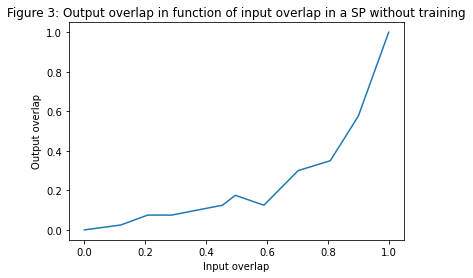

In [8]:
# パート2b.
# -------
# 2つの2値入力ベクトル間の出力の重なりは
# カラムがSPにフィードされるとアクティブになります。この部分では
# 学習をオフにして、2つのバイナリを入力したときのSPの出力を観察します
#ノイズのレベルを変化させた  入力ベクトル.
# 2つの同一のベクトルから始まる（同じアクティブな列を生成する）.
# ノイズを加えると出力が重なってしまうことが予想されます
# 減少します.
# このパートでは、出力のオーバーラップが
# 2つのベクトルの間に重なり合う入力がある
# 訓練されていない空間プーラーでも ノイズの回復力が見られる
# 高次元SDRの非線形特性のために 重なりがあることに注意してください
# この例では10ビットよりも大きい、あるいは25%よりも大きいものが有意とみなされます

x = []
y = []
for noiseLevel in np.arange(0, 1.1, 0.1):
  inputX2.setSDR( inputX1 )
  corruptSDR(inputX2, noiseLevel)

  sp.compute(inputX1, False, outputX1)
  sp.compute(inputX2, False, outputX2)

  x.append(percentOverlap(inputX1, inputX2))
  y.append(percentOverlap(outputX1, outputX2))

print("")
print("---------------------------------")
print("図3は2つの疎な表現間の出力の重なりを示しています")
print("は，入力の重なりの関数である．2つの同一のバイナリ")
print("ベクトル(同じアクティブなカラムが得られる)にノイズを追加します。")
print("それらをSPに送り、2つの間の出力の重なりを推定する")
print("それらの間の共通のアクティブなカラムの観点からの表現")
print("予想通り，入力のオーバーラップが減少するにつれて，出力のオーバーラップも減少する")
print("---------------------------------")
print("")

plt.plot(x, y)
plt.xlabel("Input overlap")
plt.ylabel("Output overlap")
plt.title("Figure 3: Output overlap in function of input overlap in a SP "
          "without training")
#plt.savefig("figure_3")
plt.show()


---------------------------------
図4aは空間的にソートされた全列のオーバラップスコアを示す
ランダム入力のプーラー、学習前と学習後。の上位2%の
アクティブなカラムを構成するオーバーラップスコアが最大のカラム
出力された疎な表現のうち、緑色で強調表示されているのは
---------------------------------


---------------------------------
学習後のノイズに対するSPのロバスト性は？
図４は，
入力の重なりの関数 トレーニング後，SPはより多くの
その入力のノイズに対するロバスト性、その結果、 -most-sigmoid曲線
これは，前の入力が再び
ある量のノイズの疎な表現はまだに似ています
オリジナル
---------------------------------



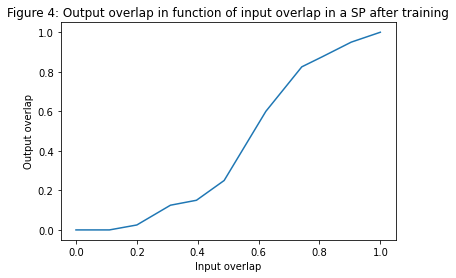

In [9]:
# パート3
# -------
# トレーニング後、SPはノイズの影響を受けにくくなります この目的のために
# train the SP by 学習をオンにして、様々なランダムなものに晒すことで、SPを訓練する
# 2値ベクトルです. での入力パターンの繰り返しにSPを晒します.
# 学習をさせて、学習が終わった後に区別するために これは
# その結果、入力のノイズに対してロバスト性を持つようになります. このセクションでは
# SPが一連の入力を学習した後の最後のセクションのプロットです. ここでは
# 学習後にSPがノイズに対する回復力の向上を示すのを見ることになるでしょう。

# 10個のランダムなベクトルを SPに提示します これを30回繰り返します
# 後で回数を変えてみるとどうなるかがわかる
# は最後のプロットを変更します。それから、例の数を変更して
# SPがどのように振る舞うか見てみましょう 例の数と
# とSPに晒した回数は？

numExamples   = 10
inputVectors  = [SDR(inputSDR.size).randomize( .50 ) for _ in range(numExamples)]
outputColumns = [SDR(outputSDR.size) for _ in range(numExamples)]

# これは、入力ベクトルをSPに提示する回数です
epochs = 30

overlapsUntrained = overlaps

for _ in range(epochs):
  for i in range(numExamples):
    # 例題をSPにフィードする
    overlaps = sp.compute(inputVectors[i], True, outputColumns[i])

print("")
print("---------------------------------")
print("図4aは空間的にソートされた全列のオーバラップスコアを示す")
print("ランダム入力のプーラー、学習前と学習後。の上位2%の")
print("アクティブなカラムを構成するオーバーラップスコアが最大のカラム")
print("出力された疎な表現のうち、緑色で強調表示されているのは")
print("---------------------------------")
print("")

plt.plot(sorted(overlapsUntrained)[::-1], label="Before learning")
plt.plot(sorted(overlaps)[::-1], label="After learning")
plt.axvspan(0, len(activeColsScores), facecolor="g", alpha=0.3, label="Active columns")
plt.legend(loc="upper right")
plt.xlabel("Columns")
plt.ylabel("Overlap scores")
plt.title("Figure 4a: Sorted column overlaps of a SP with random input.")
plt.savefig("figure_4a")
plt.close()


inputCorrupted  = SDR( inputSDR.dimensions )
outputCorrupted = SDR( outputSDR.dimensions )

x = []
y = []
# 前節の実験を繰り返しますが，入力ベクトルは1つだけです．
# 入力ベクトルの集合の中で
for noiseLevel in np.arange(0, 1.1, 0.1):
  inputCorrupted.setSDR( inputVectors[0] )
  corruptSDR(inputCorrupted, noiseLevel)

  sp.compute(inputVectors[0], False, outputColumns[0])
  sp.compute(inputCorrupted, False, outputCorrupted)

  x.append(percentOverlap(inputVectors[0], inputCorrupted))
  y.append(percentOverlap(outputColumns[0], outputCorrupted))

print("")
print("---------------------------------")
print("学習後のノイズに対するSPのロバスト性は？")
print("図４は，")
print("入力の重なりの関数 トレーニング後，SPはより多くの")
print("その入力のノイズに対するロバスト性、その結果、 -most-sigmoid曲線")
print("これは，前の入力が再び")
print("ある量のノイズの疎な表現はまだに似ています")
print("オリジナル")
print("---------------------------------")
print("")

plt.plot(x, y)
plt.xlabel("Input overlap")
plt.ylabel("Output overlap")
plt.title("Figure 4: Output overlap in function of input overlap in a SP after "
          "training")
#plt.savefig("figure_4")
plt.show()